In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
import math
import numba as nb
# from testing_sample import *
import numpy as np
from scipy.interpolate import CubicSpline
# from calibration_fitt import *
from numba import njit


In [2]:
@nb.njit
def counts_of_peak_in_index(counts,peak_index):
    counts_in_peak = []
    for i in range(len(counts)):
        if i in peak_index:
            counts_in_peak.append(counts[i])
    return counts_in_peak  

In [3]:
def gauss(x, A, x0, sigma, y0):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2)) + y0


def pseudo_voigt(x, A, x0, fwhm, eta, y0):
    """
    eta ∈ [0,1] – udział Lorentza
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    gauss_part = np.exp(-(x - x0)**2 / (2 * sigma**2))
    lorentz_part = 1 / (1 + ((x - x0) / (fwhm / 2))**2)
    return A * (eta * lorentz_part + (1 - eta) * gauss_part) + y0

In [75]:
class Data_file:
    def __init__(self,index,filename="data_storage.json"):
        self.index = index
        ''' reading data function but without hkl and everything of hkl file'''
        with open(filename, "r", encoding="utf-8") as file:
            data = json.load(file)
            sample = data[self.index]
            self.name = sample["name"]
            self.path = sample["data"]["path"] 
            self.kalpha1 = np.asarray(sample["data"]["kalpha1"][0])
            self.kalpha2 = np.asarray(sample["data"]["kalpha2"][0])
            self.theta_start = np.asarray(sample["data"]["theta_start"][0])
            self.theta_stop = np.asarray(sample["data"]["theta_stop"][0])
            self.uvw_xy = np.asarray(sample["data"]["uvw_xy"] )
            self.start_step_end = np.asarray(sample["data"]["start_step_end"] )
            self.counts = np.asarray(json.loads(sample["data"]["counts"]), dtype=float )
            self.counts_bac = np.asarray(json.loads(sample["data"]["counts_bac"] ),dtype=float)
            self.xy_and_u_fitted = sample["data"]["x_y_fitted"]
        nr_of_step = len(self.counts)
        self.x = np.linspace(self.theta_start, self.theta_stop, nr_of_step)
        if nr_of_step > 1:
            self.step = (self.theta_stop - self.theta_start) / (nr_of_step - 1)
        else:
            self.step = 0.0
        
    def del_low_intense_peaks(self):
        index = []
        for i in range(len(self.f2)):
            if self.f2[i]<100:
                index.append(i)
        return index
    
    def del_duplicates(self,two_theta,fwhm,eps=0.001):
        index = self.del_low_intense_peaks()
        temp,temp0,temp_fwhm,temp_fwhm0 = [],[],[],[]
        for i in range(len(two_theta)):
            if i in index:
                continue
            else:
                temp0.append(two_theta[i])
                temp_fwhm0.append(fwhm[i])
        for i in range(len(temp0)-1):
            if abs(temp0[i]-temp0[i+1])<eps:
                continue
            else:
                temp.append(temp0[i])
                temp_fwhm.append(temp_fwhm0[i])
        if temp0[-1] not in temp:
            temp.append(temp0[-1])
            temp_fwhm.append(temp_fwhm0[-1]) 
        return np.asarray(temp, dtype=np.float64),np.asarray(temp_fwhm, dtype=np.float64)

    def read_data_of_hkl(self,filename="data_storage.json"):
        '''function reading data hkl and everything of hkl file and reducing doubled two theta peaks '''
        with open(filename, "r", encoding="utf-8") as file:
            data = json.load(file)
            sample = data[self.index]
            self.hkl_plus = sample["data"]["hkl"][0]
        self.h = self.hkl_plus['h']
        self.k = self.hkl_plus['k']
        self.l = self.hkl_plus['l']
        self.mult = self.hkl_plus['mult']
        self.sinT_lamb = self.hkl_plus['sinT_lamb']
        self.two_theta = self.hkl_plus['tt']
        self.fwhm = self.hkl_plus['fwhm']
        self.f2 = self.hkl_plus['f2']
        self.sf2 = self.hkl_plus['sf2']
        # self.two_theta,self.fwhm = self.del_duplicates(self.two_theta,self.fwhm,0.001)

    # def without_ap(self,without_ap_counts):
    #     self.without_aparature_counts =  np.asarray(without_ap_counts, dtype=float )
        
    def find_counts_of(self,peaks):
        counts_of_peak_in_index(self.counts,peaks)
        self.two_theta_in_counts = np.asarray(peaks,dtype=int )

    # def del_bac_counts(self,only_counts):
    #     self.without_bac_counts = np.asarray(only_counts, dtype=float )
    
    def set_calibration(self,calibration_ap_fit):
        self.calibration_ap_fit = calibration_ap_fit

    def plot_counts_with_peaks_fwhm_and_fit(
        self,
        n_panels=4,
        model="gauss",     # "gauss" lub "pvoigt"
        fit_window=3.0     # ile × FWHM brać do dopasowania
    ):
        if not hasattr(self, "two_theta"):
            raise ValueError("Najpierw wywołaj read_data_of_hkl()")

        fig, axes = plt.subplots(
            n_panels, 1, figsize=(10, 2.8 * n_panels), sharex=False
        )

        if n_panels == 1:
            axes = [axes]

        theta_min = self.x.min()
        theta_max = self.x.max()
        panel_width = (theta_max - theta_min) / n_panels

        for i, ax in enumerate(axes):
            left = theta_min + i * panel_width
            right = left + panel_width

            mask = (self.x >= left) & (self.x < right)
            if not np.any(mask):
                ax.set_visible(False)
                continue

            x_seg = self.x[mask]
            y_seg = self.counts[mask]

            ax.plot(x_seg, y_seg, color="black", lw=1)

            # autoskalowanie Y
            ymin, ymax = y_seg.min(), y_seg.max()
            dy = ymax - ymin if ymax > ymin else ymax
            ax.set_ylim(ymin - 0.05 * dy, ymax + 0.15 * dy)

            for tt, fwhm in zip(self.two_theta, self.fwhm):
                if not (left <= tt < right):
                    continue

                # zaznaczenie piku
                ax.axvline(tt, color="red", linestyle="--", alpha=0.6)

                half = fwhm /2
                y_peak = np.interp(tt, self.x, self.counts)

                ax.hlines(
                    y_peak / 2,
                    tt - half,
                    tt + half,
                    color="blue",
                    linewidth=2
                )

                # -------- FIT --------
                window = fit_window * fwhm
                fit_mask = (self.x > tt - window) & (self.x < tt + window)

                if np.sum(fit_mask) < 5:
                    continue

                x_fit = self.x[fit_mask]
                y_fit = self.counts[fit_mask]

                try:
                    if model == "gauss":
                        p0 = [y_peak, tt, fwhm / 2.355, np.min(y_fit)]
                        popt, _ = curve_fit(gauss, x_fit, y_fit, p0=p0)
                        x_dense = np.linspace(x_fit.min(), x_fit.max(), 400)
                        ax.plot(
                            x_dense,
                            gauss(x_dense, *popt),
                            color="green",
                            lw=2
                        )

                    elif model == "pvoigt":
                        p0 = [y_peak, tt, fwhm, 0.5, np.min(y_fit)]
                        bounds = (
                            [0, tt - fwhm, 0, 0, 0],
                            [np.inf, tt + fwhm, np.inf, 1, np.inf]
                        )
                        popt, _ = curve_fit(
                            pseudo_voigt,
                            x_fit,
                            y_fit,
                            p0=p0,
                            bounds=bounds
                        )
                        x_dense = np.linspace(x_fit.min(), x_fit.max(), 400)
                        ax.plot(
                            x_dense,
                            pseudo_voigt(x_dense, *popt),
                            color="darkorange",
                            lw=2
                        )

                except RuntimeError:
                    pass  # brak zbieżności fitu – ignorujemy

            ax.set_xlim(left, right)
            ax.set_ylabel("Counts")
            ax.grid(True, alpha=0.3)

        axes[-1].set_xlabel(r"$2\theta$")
        fig.suptitle(
            f"XRD: piki + FWHM + dopasowanie ({model}) – {self.name}",
            fontsize=14
        )
        plt.tight_layout()
        plt.show()

    def scherrer_size(self, wavelength=1.5406, K=1):
        sizes = []
        for tt, fwhm in zip(self.two_theta, self.fwhm):
            theta = np.deg2rad(tt / 2)
            beta = np.deg2rad(fwhm)  # w radianach

            if beta > 0:
                D = K * wavelength / (beta * np.cos(theta))
                sizes.append((tt, D))

        return np.array(sizes)




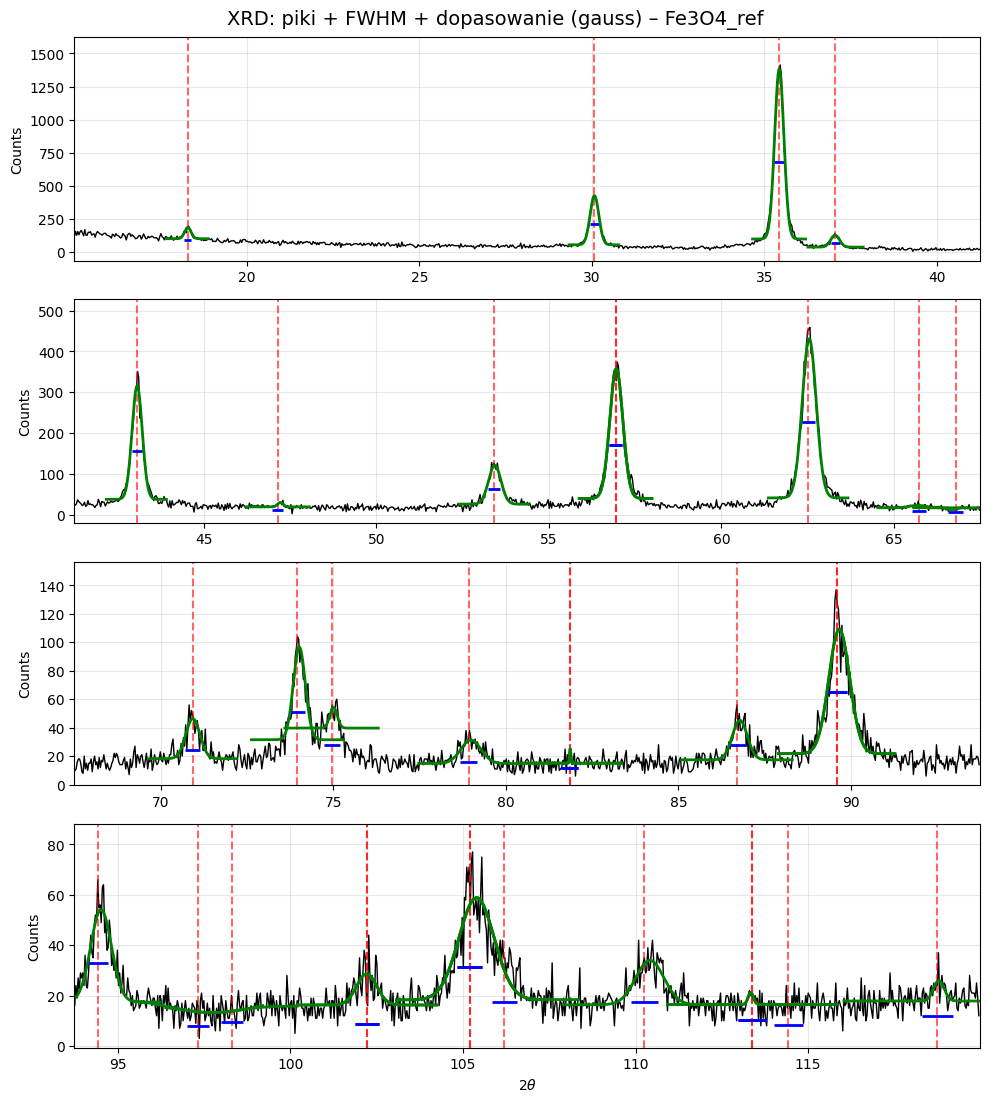

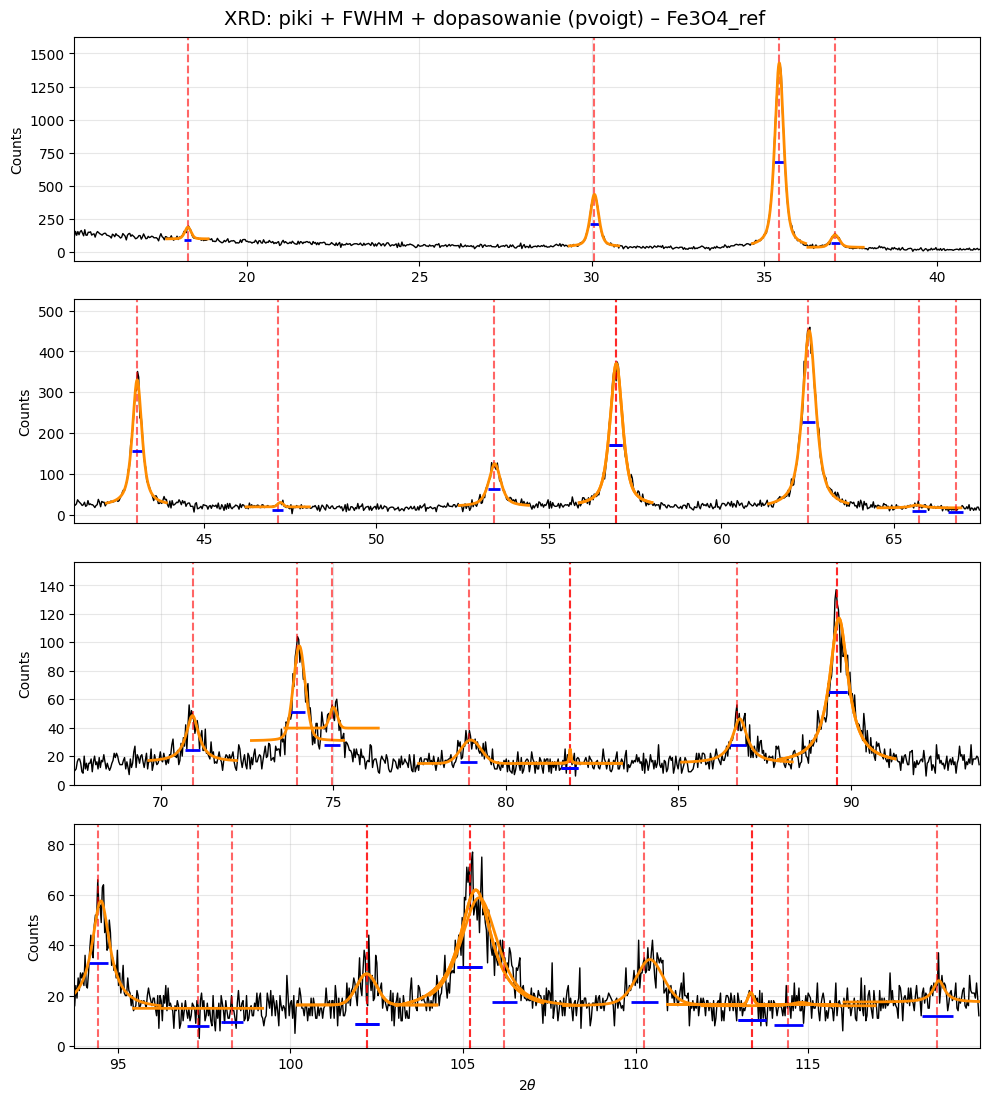

In [76]:
#create class element - aparature
ap = Data_file(-1)
#create class element - sample
f = Data_file(0)
f.read_data_of_hkl()
# Gauss
f.plot_counts_with_peaks_fwhm_and_fit(model="gauss")

# pseudo-Voigt (zalecane do XRD)
f.plot_counts_with_peaks_fwhm_and_fit(model="pvoigt")




In [6]:
print(len(f.two_theta))
print(len(f.fwhm))

34
34


In [7]:
PI = 3.141592654


In [8]:
print(f.two_theta[2])
print(f.two_theta[4])
print(f.two_theta[7])
print(f.two_theta[9])

35.4233
43.0505
56.9313
62.5158


0.09077984473984213
34.47585886229992
16.970705385265447


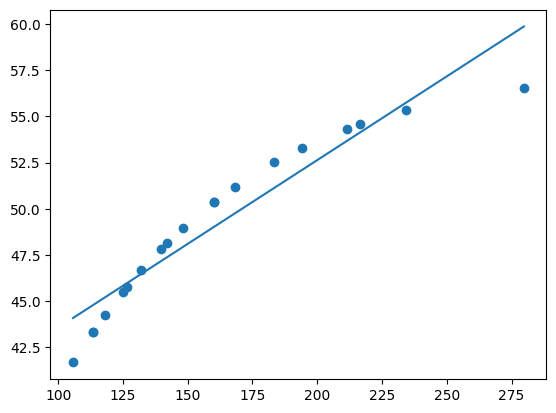

In [9]:
xline,yline = [],[]
for i in range(len(f.two_theta)-15):
    xline.append(1/(f.fwhm[i]*PI/180))
    yline.append(180*math.cos(f.two_theta[i]/2*PI/180)/PI)
# xline = [1/(f.fwhm[2]*PI/180),1/(f.fwhm[4]*PI/180),1/(f.fwhm[7]*PI/180),1/(f.fwhm[9]*PI/180)]
# yline = [180*math.cos(f.two_theta[2]/2*PI/180)/PI,180*math.cos(f.two_theta[4]/2*PI/180)/PI,180*math.cos(f.two_theta[7]/2*PI/180)/PI,180*math.cos(f.two_theta[9]/2*PI/180)/PI]
plt.scatter(xline,yline)
aschr, bschr= np.polyfit(xline, yline, 1)
y_line = []
for i in range(len(xline)):
    y_line.append(aschr*xline[i]+bschr)
plt.plot(xline,y_line)
print(aschr)
print(bschr)
size_schr = 1*f.kalpha1/aschr
print(size_schr)

2.913160870640778
-5.506601942990669
379.46888185666836


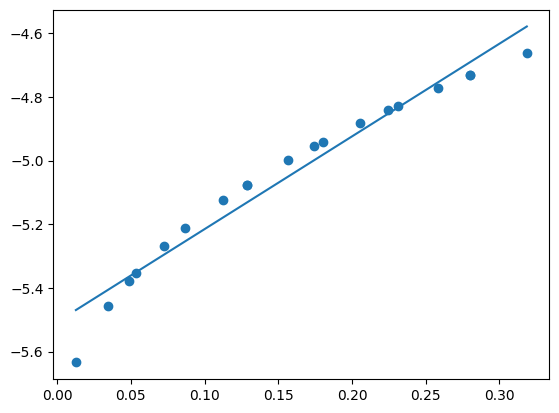

In [10]:
# yline = [math.log(f.fwhm[2]*PI/180),math.log(f.fwhm[4]*PI/180),math.log(f.fwhm[7]*PI/180),math.log(f.fwhm[9]*PI/180)]
# xline = [math.log(1/(math.cos(f.two_theta[2]/2*PI/180))),math.log(1/(math.cos(f.two_theta[4]/2*PI/180))),math.log(1/(math.cos(f.two_theta[7]/2*PI/180))),math.log(1/(math.cos(f.two_theta[9]/2*PI/180)))]
xline,yline = [],[]
for i in range(len(f.two_theta)-15):
    xline.append(math.log(1/(math.cos(f.two_theta[i]/2*PI/180))))
    yline.append(math.log(f.fwhm[i]*PI/180))
plt.scatter(xline,yline)

aschr, bschr= np.polyfit(xline, yline, 1)
y_line = []
for i in range(len(xline)):
    y_line.append(aschr*xline[i]+bschr)
plt.plot(xline,y_line)
print(aschr)
print(bschr)
size_schr = 1*f.kalpha1/math.e**bschr
print(size_schr)

In [11]:
@njit
def gaussian(x, A, x0, sigma):
    return A * np.exp(-0.5 * ((x - x0) / sigma) ** 2)

In [12]:
@njit
def rr2(x_fit,y_fit,A_guess, x0_guess, sigma_guess):
    fit_y = gaussian(x_fit, A_guess, x0_guess, sigma_guess)
    ss_res = np.sum((y_fit - fit_y) ** 2)
    ss_tot = np.sum((y_fit - np.mean(y_fit)) ** 2)
    return  1 - ss_res / ss_tot

In [13]:
def peak_detect_gauss_quality(counts, x, r2_min=0.9, fit_range=10, height=None, distance=None, prominence=None):
    """
    Peak detection + Gaussian fitting with R² quality filter.
    Returns:
        good_peaks : np.ndarray (indices)
        x_peaks    : np.ndarray (x values of peaks)
        y_peaks    : np.ndarray (y values of peaks)
        gauss_fit  : list of fitted parameters [A, mu, sigma]
        r2_list    : list of R² values
    """
    peaks, _ = find_peaks(
        counts,
        height=height,
        distance=distance,
        prominence=prominence
    )
    if len(peaks) == 0:
        return np.array([]), np.array([]), np.array([]), [], []

    good_peaks, x_peaks, y_peaks, gauss_fit, r2_list = [],[],[],[],[]
    for pk in peaks:
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)
        x_fit = x[left:right]
        y_fit = counts[left:right]
        A0 = counts[pk]
        mu0 = x[pk]
        sigma0 = (x_fit[-1] - x_fit[0]) / 6 if len(x_fit) > 1 else 1.0
        try:
            popt, _ = curve_fit(
                gaussian,
                x_fit,
                y_fit,
                p0=[A0, mu0, sigma0],
                bounds=(
                    [0.0, mu0 - fit_range, 1e-3],
                    [np.inf, mu0 + fit_range, np.inf]
                )
            )
            r2 = rr2(x_fit, y_fit, *popt)
            if r2 >= r2_min:
                good_peaks.append(pk)
                x_peaks.append(x[pk])
                y_peaks.append(counts[pk])
                gauss_fit.append(popt)
                r2_list.append(r2)
        except RuntimeError:
            continue
    return np.array(y_peaks),gauss_fit,r2_list

In [14]:
def finding_fwhm_ap(peaks, gauss_fit):
    """
    Calculate FWHM and peak positions from Gaussian fit parameters.
    gauss_fit: array-like of shape (N, 3)
        Each row: [A, mu, sigma]
    """
    peaks = np.asarray(peaks)
    peaks_max = np.max(peaks)
    peaks_weight = np.zeros(len(peaks))
    peaks_weight = peaks/peaks_max

    gauss_fit = np.asarray(gauss_fit)
    sigma = np.abs(gauss_fit[:, 2])
    mu = gauss_fit[:, 1]

    fwhm = 2 * sigma * np.sqrt(2 * np.log(2))
    t_fwhm = mu
    return fwhm, t_fwhm, peaks_weight

In [15]:
def fit_poly_lower(x, y, weight, x_min=60, q=0.2, deg=1, log_weight=False ):
    x = np.asarray(x)
    y = np.asarray(y)
    weight = np.asarray(weight)
    mask = x >= x_min
    x0 = x[mask]
    y0 = y[mask]
    w0 = weight[mask]

    if len(x0) < deg + 1:
        return (
            np.full_like(x, np.nan, dtype=float),
            None,
            np.full_like(x, np.nan, dtype=float)
        )
    coeffs = np.polyfit(x0, y0, deg, w=w0)
    poly = np.poly1d(coeffs)
    y_fit = poly(x)
    y_fit[x < x_min] = np.nan

    w = weight.astype(float)
    if log_weight:
        w = np.log1p(w)
    w_min, w_max = np.nanmin(w), np.nanmax(w)
    if w_max > w_min:
        w_norm = (w - w_min) / (w_max - w_min)
    else:
        w_norm = np.zeros_like(w)
    w_norm[x < x_min] = np.nan
    return y_fit, poly, w_norm

In [16]:
def set_aparature_fit(counts,x,r2_min = 0.6,plotting = False,height=None,dist=None,prom=None):
    ap_good_peaks_counts,ap_gauss_fit,_ = peak_detect_gauss_quality(counts,x,r2_min,height=height, distance=dist, prominence=prom)
    ap_fwhm,ap_t_fwhm,ap_peaks_weight = finding_fwhm_ap(ap_good_peaks_counts,ap_gauss_fit)
    y_fit,poly, colorscale = fit_poly_lower(ap_t_fwhm, ap_fwhm,ap_peaks_weight, x_min=0, q=0.2, deg=2)

    if plotting == True:
        plt.figure(figsize=(8, 5))
        plt.scatter(ap_t_fwhm, ap_fwhm, s=30, alpha=0.7, label="dane", c=colorscale,cmap="viridis")
        plt.plot(ap_t_fwhm, y_fit, linewidth=2, label=f"polyfit deg={poly.order}")
        plt.colorbar(label="Znaczenie punktu")
        plt.legend()
        plt.grid(True)
        plt.show()
    return y_fit,ap_t_fwhm

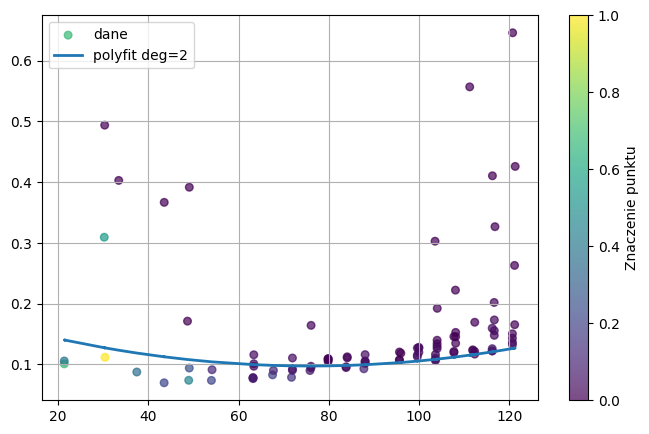

In [17]:
# y_ap_fit0,ap_x_fit0 = set_aparature_fit(ap.counts,ap.x,plotting=True)
y_ap_fit,ap_x_fit = set_aparature_fit(ap.counts,ap.x,plotting=True,height=20,prom=1)


In [18]:
# idx = np.argsort(ap_x_fit0)
# x = ap_x_fit0[idx]
# y = y_ap_fit0[idx]
# # spline
# cs = CubicSpline(x, y)
# # gęsta siatka X
# x_dense = np.linspace(x.min(), x.max(), 1000)
# y_dense = cs(x_dense)

# plt.figure(figsize=(8,5))
# plt.plot(x, y, 'o', label='oryginalne punkty',color = "red")
# plt.plot(x_dense, y_dense, '-', label='interpolacja spline')
# plt.scatter(x_dense, y_dense, label='interpolacja spline')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.grid(True)
# plt.show()
# y_two_theta_fit = cs(f.two_theta)


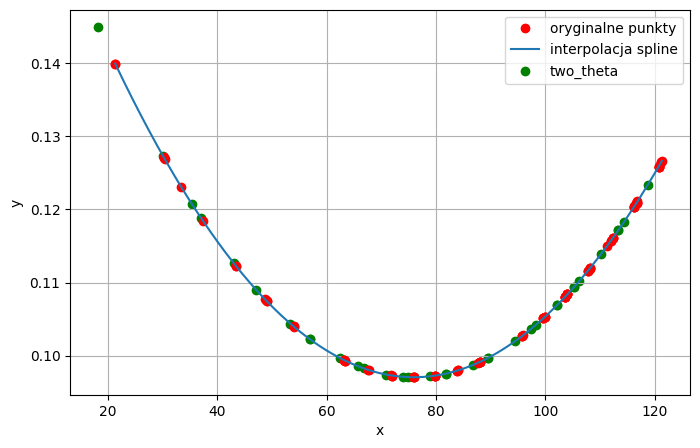

In [19]:

idx1 = np.argsort(ap_x_fit)
x1 = ap_x_fit[idx1]
y1 = y_ap_fit[idx1]


from scipy.interpolate import CubicSpline

# spline
cs1 = CubicSpline(x1, y1)

# gęsta siatka X
x_dense1 = np.linspace(x1.min(), x1.max(), 1000)
y_dense1 = cs1(x_dense1)

import matplotlib.pyplot as plt

y_two_theta_fit1 = cs1(f.two_theta)

plt.figure(figsize=(8,5))
plt.plot(x1, y1, 'o', label='oryginalne punkty',color = "red")
plt.plot(x_dense1, y_dense1, '-', label='interpolacja spline')
plt.scatter(f.two_theta, y_two_theta_fit1, label='two_theta',color = "green")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
@njit
def find_index_of_two_theta(two_theta,theta_start,step):
    '''function finding peak index in range of x where peak from two theta extsts'''
    peaks = np.zeros(len(two_theta))
    for i in range(len(two_theta)):
        peaks[i] = (two_theta[i]-theta_start)/step
    for i in range(len(peaks)):
        if peaks[i]-int(peaks[i])>0.5:
            peaks[i] = int(peaks[i]+1)
        else:
            peaks[i] = int(peaks[i]) 
    return peaks

In [21]:
f.find_counts_of(find_index_of_two_theta(f.two_theta,f.theta_start,f.step))
print(f.two_theta_in_counts)
print(f.two_theta)

[  98  451  611  660  839  961 1149 1254 1254 1422 1518 1549 1673 1764
 1794 1912 2000 2000 2145 2232 2232 2376 2463 2492 2609 2609 2699 2699
 2728 2850 2943 2943 2975 3104]
[18.2835, 30.0743, 35.4233, 37.0544, 43.0505, 47.1354, 53.4069, 56.9313, 56.9313, 62.5158, 65.7311, 66.7844, 70.9205, 73.9548, 74.9556, 78.9155, 81.8496, 81.8496, 86.6961, 89.5905, 89.5905, 94.4157, 97.3238, 98.297, 102.2171, 102.2171, 105.1947, 105.1947, 106.1962, 110.2575, 113.3736, 113.3735, 114.4282, 118.7419]


In [22]:
def plot_with_theta_sample(counts,name,two_theta,x):
    plt.plot(x, counts, label="Dane próbki", color="blue")
    for i in range(len(two_theta)):
        plt.axvline(two_theta[i], color='red', linestyle='--', linewidth=0.5)
    plt.xlabel(r"2$\theta$")
    plt.ylabel("Liczba zliczeń")
    plt.title(f"Widmo próbki \"{name}\" z zaznaczeniem istniejących pików")
    plt.legend()
    plt.show()

Plot all counts


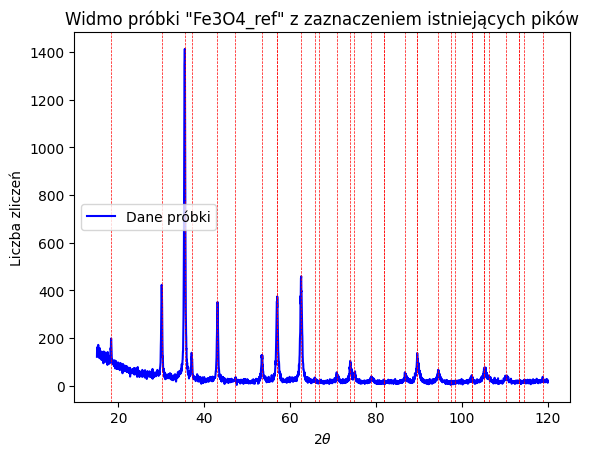

Plot without background counts
Plot without background and aparature counts


In [23]:
print("Plot all counts")
plot_with_theta_sample(f.counts,f.name,f.two_theta,f.x)
print("Plot without background counts")
# plot_with_theta_sample(f.without_bac_counts,f.name,f.two_theta,f.x)
print("Plot without background and aparature counts")
# plot_with_theta_sample(f.without_aparature_counts,f.name,f.two_theta,f.x)

In [24]:
counts_in_peak  = counts_of_peak_in_index(f.counts,f.two_theta_in_counts)
print(min(counts_in_peak))
print(max(counts_in_peak ))
print((f.two_theta_in_counts))

16.0
1365.0
[  98  451  611  660  839  961 1149 1254 1254 1422 1518 1549 1673 1764
 1794 1912 2000 2000 2145 2232 2232 2376 2463 2492 2609 2609 2699 2699
 2728 2850 2943 2943 2975 3104]


In [25]:
#parameters to calculate stain and size of cristalite
print(f.xy_and_u_fitted)
print(f.uvw_xy)

[0.42234, 0.00771505, 0.08509, 0.00285621]
[ 4.39100e-03 -3.89000e-04  9.81300e-03  4.22342e-01  8.50950e-02
  0.00000e+00  0.00000e+00  0.00000e+00]


In [26]:
def plot_gauss_ap(peaks,count,x,segment_width = 15):
    x_min = np.min(x)
    x_max = np.max(x)
    # szerokość segmentu (np. 20° 2θ)
    num_segments = int(np.ceil((x_max - x_min) / segment_width))
    print(f"\nTworzę {num_segments} wykresów (co {segment_width}° 2θ)...")
    for seg in range(num_segments):
        seg_start = x_min + seg * segment_width
        seg_end = seg_start + segment_width
        mask = (x >= seg_start) & (x < seg_end)
        if not np.any(mask):
            continue
        x_seg = x[mask]
        y_seg = count[mask]
        plt.figure(figsize=(8, 5))
        plt.plot(x_seg, y_seg, label='Dane (po baseline)', alpha=0.6)
        local_peaks = [pk for pk in peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_peaks], count[local_peaks], color='k', zorder=10, label='Piki')
        plt.xlim(seg_start, seg_end)
        plt.ylim(y_seg.min() * 0.9, y_seg.max() * 1.1)
        plt.title(f'Dopasowanie Gaussów: {seg_start:.1f}–{seg_end:.1f}° 2θ')
        plt.xlabel('2θ [°]')
        plt.ylabel('Intensywność')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()


In [27]:
def checking_what_found(peaks,counts,correct_peaks,two_theta,x):
    plt.plot(two_theta,counts[two_theta])


spróbować dopasować aparaturę ale tak żeby odejmować od pików wkład piku a nie po prostu 
sprawdzić możliwości find_peaks czy da się wprowadzić inny model do dopasowania i ewentualnie go dodać do naszych danych
sprawdzić jak można wprowadzić wkład lagranżowski do danych 
przygotować przezentacje - pare slajdów o otrzymanych danych, wykresach co moznaby ewentualnie dodać do pracy 


In [28]:
def plot_gauss(correct_peaks,peaks,count,x,two_theta,segment_width = 15):
    x_min = np.min(x)
    x_max = np.max(x)
    # szerokość segmentu (np. 20° 2θ)
    num_segments = int(np.ceil((x_max - x_min) / segment_width))
    print(f"\nTworzę {num_segments} wykresów (co {segment_width}° 2θ)...")
    for seg in range(num_segments):
        seg_start = x_min + seg * segment_width
        seg_end = seg_start + segment_width
        mask = (x >= seg_start) & (x < seg_end)
        if not np.any(mask):
            continue
        x_seg = x[mask]
        y_seg = count[mask]
        plt.figure(figsize=(8, 5))
        plt.plot(x_seg, y_seg, label='Dane (po baseline)', alpha=0.6)
        local_peaks = [pk for pk in peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_peaks], count[local_peaks], color='k', zorder=10, label='Piki')
        local_corr_peaks = [pk for pk in correct_peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_corr_peaks], count[local_corr_peaks], color='red', zorder=10, label='Piki poprawne')
        for i in range(len(two_theta)):
            plt.axvline(two_theta[i], color='red', linestyle='--', linewidth=0.5)
        plt.xlim(seg_start, seg_end)
        plt.ylim(y_seg.min() * 0.9, y_seg.max() * 1.1)
        plt.title(f'Dopasowanie Gaussów: {seg_start:.1f}–{seg_end:.1f}° 2θ')
        plt.xlabel('2θ [°]')
        plt.ylabel('Intensywność')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()

In [29]:
# peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect_ap(ap.counts,ap.x,0, 10, 0.001,ap.theta_start,ap.step,4,True,True,fit_range=500)


In [30]:
def which_was_found(correct_peaks, x, counts, two_theta, two_theta_in_counts):
    plt.plot(x, counts, color="orange",linestyle='--', linewidth=0.5)
    plt.scatter(x[correct_peaks], counts[correct_peaks], color="green",label="piki znalezione przez algorytm")
    plt.scatter(two_theta, counts[two_theta_in_counts],color="blue", label="piki wzorcowe")
    plt.xlabel("2θ [stopnie]")
    plt.ylabel("Ilość zliczeń")
    plt.title("Porównanie pików znalezionych i wzorcowych")
    plt.legend()
    plt.show()
    eps = [0, 1, 2, 3, -1, -2, -3]
    find_peaks_theta = []
    not_find_peaks = []
    correct_peaks_set = set(correct_peaks)
    for idx in two_theta_in_counts:
        matched = any((idx + e) in correct_peaks_set for e in eps)
        if matched:
            find_peaks_theta.append(idx)
        else:
            not_find_peaks.append(idx)
    plt.figure()
    # plt.plot(x, counts, color="orange")
    # plt.title("Zebranie pików odnalezionych i nie odnalezionych przez algorytm")
    plt.title("Znalezione i nieznalezione piki (dokładność ±3 punkty)")
    plt.scatter(
        x[find_peaks_theta],
        counts[find_peaks_theta],
        label=fr"znalezione piki: {len(find_peaks_theta)}/{len(two_theta)}",
        color = "blue"
    )
    plt.legend()
    plt.xlabel("2θ [stopnie]")
    plt.ylabel("Ilość zliczeń")
    # plt.show()
    # plt.title("nie znalezione")
    # plt.plot(x, counts, color="orange")
    plt.scatter(
        x[not_find_peaks],
        counts[not_find_peaks],
        label=fr"nieznalezione piki: {len(not_find_peaks)}/{len(two_theta)}",
        color = "red"
    )
    plt.axhline(np.max(counts[not_find_peaks]),label = fr"maksymalna nieznaleziona liczba zliczeń: {np.max(counts[not_find_peaks])} ",color="red",linestyle='--', linewidth=0.6)
    plt.legend()
    plt.show()
    return find_peaks_theta

In [33]:
# peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect(f.counts,f.x,5, 55, 0.001,f.two_theta,f.theta_start,f.step,4,False,True)
# fwhm,t_fwhm,diff = finding_fwhm_plot(f.without_aparature_counts,index_corrected,f.x,gauss_fit,f.theta_start,f.step,plotting = True)
# finding_fwhm(f.counts,correct_peaks,index_corrected,f.x,gauss_fit)

# which_was_found(correct_peaks,f.x,f.counts,f.two_theta,f.two_theta_in_counts)
# which_was_found(peaks,f.x,f.counts,f.two_theta,f.two_theta_in_counts)



In [34]:
print(f.fwhm)
print(f.two_theta)
# print(f.two_theta_in_counts)
print(len(f.fwhm))
print(len(f.two_theta))

[0.20478, 0.24475, 0.2646, 0.27089, 0.29502, 0.31244, 0.3409, 0.35789, 0.35789, 0.38649, 0.40397, 0.40987, 0.43394, 0.45259, 0.45894, 0.48508, 0.50559, 0.50559, 0.54188, 0.56514, 0.56514, 0.60698, 0.63426, 0.64378, 0.68427, 0.68427, 0.71758, 0.71758, 0.72933, 0.78014, 0.82297, 0.82297, 0.83832, 0.90623]
[18.2835, 30.0743, 35.4233, 37.0544, 43.0505, 47.1354, 53.4069, 56.9313, 56.9313, 62.5158, 65.7311, 66.7844, 70.9205, 73.9548, 74.9556, 78.9155, 81.8496, 81.8496, 86.6961, 89.5905, 89.5905, 94.4157, 97.3238, 98.297, 102.2171, 102.2171, 105.1947, 105.1947, 106.1962, 110.2575, 113.3736, 113.3735, 114.4282, 118.7419]
34
34


In [35]:
def peak_detect_gauss_quality(counts, x, r2_min=0.9, fit_range=10, height=None, distance=None, prominence=None):
    """
    Peak detection + Gaussian fitting with R² quality filter.
    Returns:
        good_peaks : np.ndarray (indices)
        x_peaks    : np.ndarray (x values of peaks)
        y_peaks    : np.ndarray (y values of peaks)
        gauss_fit  : list of fitted parameters [A, mu, sigma]
        r2_list    : list of R² values
    """
    peaks, _ = find_peaks(
        counts,
        height=height,
        distance=distance,
        prominence=prominence
    )
    if len(peaks) == 0:
        return np.array([]), np.array([]), np.array([]), [], []

    good_peaks, x_peaks, y_peaks, gauss_fit, r2_list = [],[],[],[],[]
    for pk in peaks:
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)
        x_fit = x[left:right]
        y_fit = counts[left:right]
        A0 = counts[pk]
        mu0 = x[pk]
        sigma0 = (x_fit[-1] - x_fit[0]) / 6 if len(x_fit) > 1 else 1.0
        try:
            popt, _ = curve_fit(
                gaussian,
                x_fit,
                y_fit,
                p0=[A0, mu0, sigma0],
                bounds=(
                    [0.0, mu0 - fit_range, 1e-3],
                    [np.inf, mu0 + fit_range, np.inf]
                )
            )
            r2 = rr2(x_fit, y_fit, *popt)
            if r2 >= r2_min:
                good_peaks.append(pk)
                x_peaks.append(x[pk])
                y_peaks.append(counts[pk])
                gauss_fit.append(popt)
                r2_list.append(r2)
        except RuntimeError:
            continue
    return np.array(y_peaks),np.array(x_peaks),np.array(good_peaks),gauss_fit,r2_list

In [73]:
y_peaks_f,x_peaks_f,index_peaks_f,gauss_fit,_ = peak_detect_gauss_quality(f.counts,f.x,r2_min=0.6)


In [71]:
def plot_counts_with_peaks_fwhm_and_fit_from_peaks(
    counts,
    x,
    peak_indices,
    gauss_fit,
    model="gauss",      # "gauss" albo "pvoigt"
    n_panels=4,
    fit_window=3.0
):
    """
    Rysuje:
    - widmo XRD
    - piki znalezione algorytmem
    - FWHM (z fitu Gaussa)
    - dopasowanie Gauss / pseudo-Voigt

    Jednostki:
    x        -> 2θ [stopnie]
    sigma    -> stopnie (2θ)
    fwhm     -> stopnie (2θ)
    """

    fig, axes = plt.subplots(
        n_panels, 1, figsize=(10, 2.8 * n_panels), sharex=False
    )

    if n_panels == 1:
        axes = [axes]

    theta_min = x.min()
    theta_max = x.max()
    panel_width = (theta_max - theta_min) / n_panels

    for i, ax in enumerate(axes):
        left = theta_min + i * panel_width
        right = left + panel_width

        mask = (x >= left) & (x < right)
        if not np.any(mask):
            ax.set_visible(False)
            continue

        x_seg = x[mask]
        y_seg = counts[mask]

        ax.plot(x_seg, y_seg, color="black", lw=1)

        ymin, ymax = y_seg.min(), y_seg.max()
        dy = ymax - ymin if ymax > ymin else ymax
        ax.set_ylim(ymin - 0.05 * dy, ymax + 0.15 * dy)

        # --- piki ---
        for pk, popt in zip(peak_indices, gauss_fit):
            mu = popt[1]
            sigma = abs(popt[2])
            fwhm = 2 * sigma * np.sqrt(2 * np.log(2))

            if not (left <= mu < right):
                continue

            # pozycja piku
            ax.axvline(mu, color="red", linestyle="--", alpha=0.6)

            y_peak = counts[pk]

            # FWHM
            ax.hlines(
                y_peak / 2,
                mu - fwhm / 2,
                mu + fwhm / 2,
                color="blue",
                linewidth=2
            )

            # -------- FIT --------
            window = fit_window * fwhm
            fit_mask = (x > mu - window) & (x < mu + window)
            if np.sum(fit_mask) < 5:
                continue

            x_fit = x[fit_mask]
            y_fit = counts[fit_mask]

            x_dense = np.linspace(x_fit.min(), x_fit.max(), 400)

            if model == "gauss":
                ax.plot(
                    x_dense,
                    gaussian(x_dense, *popt),
                    color="green",
                    lw=2
                )

            elif model == "pvoigt":
                A = popt[0]
                y0 = np.min(y_fit)
                p0 = [A, mu, fwhm, 0.5, y0]
                bounds = (
                    [0, mu - fwhm, 0, 0, 0],
                    [np.inf, mu + fwhm, np.inf, 1, np.inf]
                )
                try:
                    popt_v, _ = curve_fit(
                        pseudo_voigt,
                        x_fit,
                        y_fit,
                        p0=p0,
                        bounds=bounds
                    )
                    ax.plot(
                        x_dense,
                        pseudo_voigt(x_dense, *popt_v),
                        color="darkorange",
                        lw=2
                    )
                except RuntimeError:
                    pass

        ax.set_xlim(left, right)
        ax.set_ylabel("Counts")
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel(r"$2\theta$ [°]")
    fig.suptitle(
        f"XRD: piki + FWHM + dopasowanie ({model})",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()


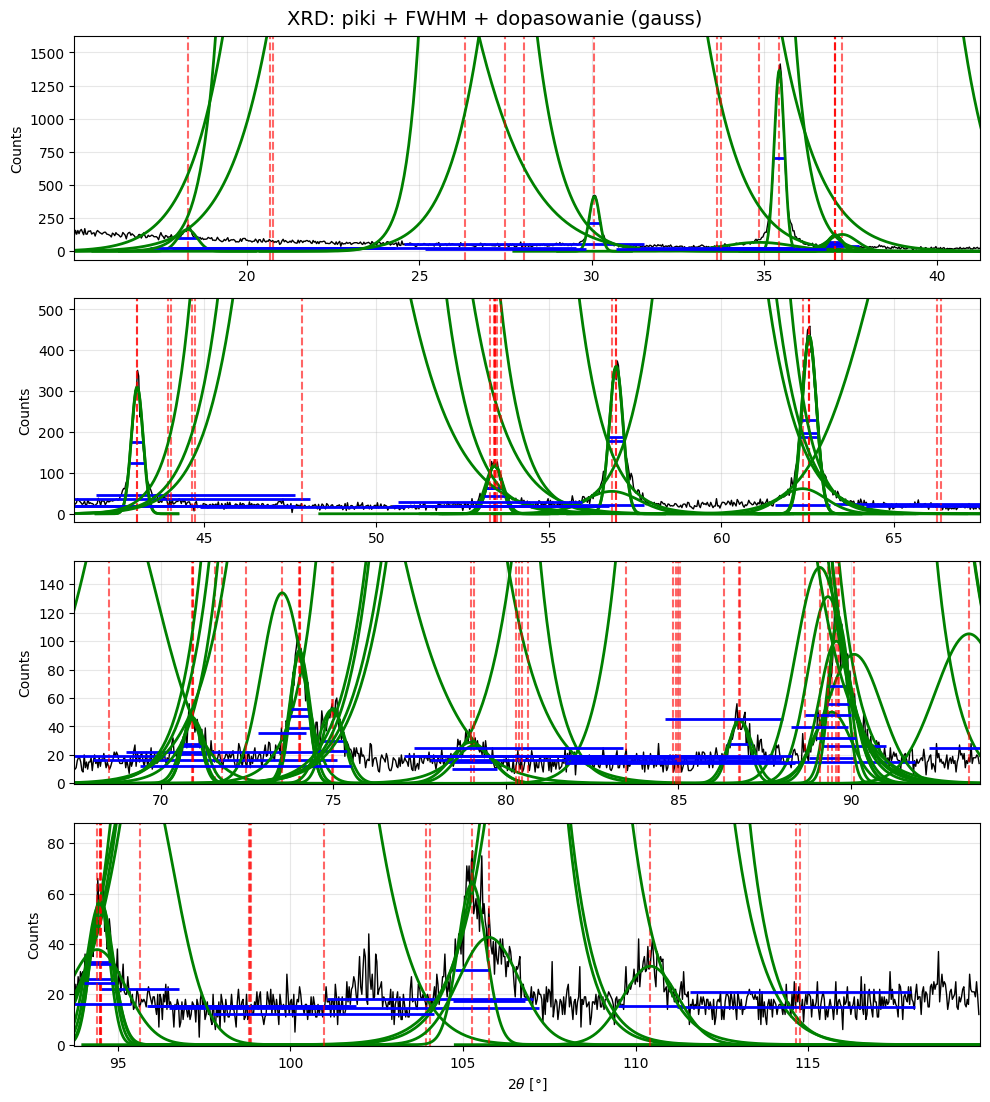

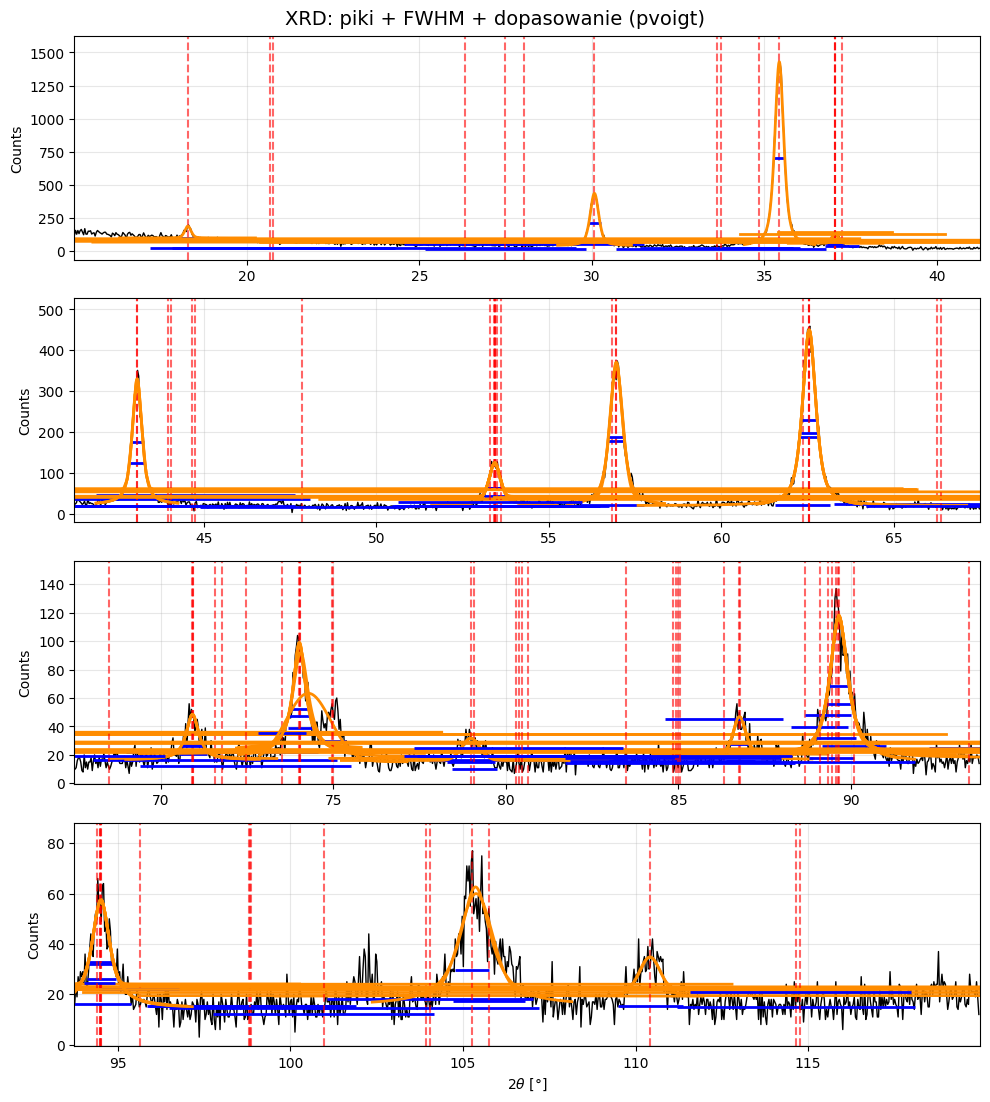

In [72]:
y_peaks, x_peaks, peak_idx, gauss_fit, r2 = peak_detect_gauss_quality(
    f.counts,
    f.x,
    r2_min=0.6,
    prominence=1
)

plot_counts_with_peaks_fwhm_and_fit_from_peaks(
    counts=f.counts,
    x=f.x,
    peak_indices=peak_idx,
    gauss_fit=gauss_fit,
    model="gauss"
)

plot_counts_with_peaks_fwhm_and_fit_from_peaks(
    counts=f.counts,
    x=f.x,
    peak_indices=peak_idx,
    gauss_fit=gauss_fit,
    model="pvoigt"
)


In [ ]:
def plot_counts_with_peaks_fwhm_and_fit(
        self,
        n_panels=4,
        model="gauss",     # "gauss" lub "pvoigt"
        fit_window=3.0     # ile × FWHM brać do dopasowania
    ):
        if not hasattr(self, "two_theta"):
            raise ValueError("Najpierw wywołaj read_data_of_hkl()")

        fig, axes = plt.subplots(
            n_panels, 1, figsize=(10, 2.8 * n_panels), sharex=False
        )

        if n_panels == 1:
            axes = [axes]

        theta_min = self.x.min()
        theta_max = self.x.max()
        panel_width = (theta_max - theta_min) / n_panels

        for i, ax in enumerate(axes):
            left = theta_min + i * panel_width
            right = left + panel_width

            mask = (self.x >= left) & (self.x < right)
            if not np.any(mask):
                ax.set_visible(False)
                continue

            x_seg = self.x[mask]
            y_seg = self.counts[mask]

            ax.plot(x_seg, y_seg, color="black", lw=1)

            # autoskalowanie Y
            ymin, ymax = y_seg.min(), y_seg.max()
            dy = ymax - ymin if ymax > ymin else ymax
            ax.set_ylim(ymin - 0.05 * dy, ymax + 0.15 * dy)

            for tt, fwhm in zip(self.two_theta, self.fwhm):
                if not (left <= tt < right):
                    continue

                # zaznaczenie piku
                ax.axvline(tt, color="red", linestyle="--", alpha=0.6)

                half = fwhm 
                y_peak = np.interp(tt, self.x, self.counts)

                ax.hlines(
                    y_peak / 2,
                    tt - half,
                    tt + half,
                    color="blue",
                    linewidth=2
                )

                # -------- FIT --------
                window = fit_window * fwhm
                fit_mask = (self.x > tt - window) & (self.x < tt + window)

                if np.sum(fit_mask) < 5:
                    continue

                x_fit = self.x[fit_mask]
                y_fit = self.counts[fit_mask]

                try:
                    if model == "gauss":
                        p0 = [y_peak, tt, fwhm / 2.355, np.min(y_fit)]
                        popt, _ = curve_fit(gauss, x_fit, y_fit, p0=p0)
                        x_dense = np.linspace(x_fit.min(), x_fit.max(), 400)
                        ax.plot(
                            x_dense,
                            gauss(x_dense, *popt),
                            color="green",
                            lw=2
                        )

                    elif model == "pvoigt":
                        p0 = [y_peak, tt, fwhm, 0.5, np.min(y_fit)]
                        bounds = (
                            [0, tt - fwhm, 0, 0, 0],
                            [np.inf, tt + fwhm, np.inf, 1, np.inf]
                        )
                        popt, _ = curve_fit(
                            pseudo_voigt,
                            x_fit,
                            y_fit,
                            p0=p0,
                            bounds=bounds
                        )
                        x_dense = np.linspace(x_fit.min(), x_fit.max(), 400)
                        ax.plot(
                            x_dense,
                            pseudo_voigt(x_dense, *popt),
                            color="darkorange",
                            lw=2
                        )

                except RuntimeError:
                    pass  # brak zbieżności fitu – ignorujemy

            ax.set_xlim(left, right)
            ax.set_ylabel("Counts")
            ax.grid(True, alpha=0.3)

        axes[-1].set_xlabel(r"$2\theta$")
        fig.suptitle(
            f"XRD: piki + FWHM + dopasowanie ({model}) – {self.name}",
            fontsize=14
        )
        plt.tight_layout()
        plt.show()

    def scherrer_size(self, wavelength=1.5406, K=1):
        sizes = []
        for tt, fwhm in zip(self.two_theta, self.fwhm):
            theta = np.deg2rad(tt / 2)
            beta = np.deg2rad(fwhm)  # w radianach

            if beta > 0:
                D = K * wavelength / (beta * np.cos(theta))
                sizes.append((tt, D))

        return np.array(sizes)




In [70]:
plot_counts_with_peaks_fwhm_and_fit(
    y_peaks_f,x_peaks_f,index_peaks_f,
    name = '',
    n_panels=4,
    model="gauss",     # "gauss" lub "pvoigt"
    fit_window=3.0     # ile × FWHM brać do dopasowania
)

TypeError: hasattr expected 2 arguments, got 1


Tworzę 7 wykresów (co 15° 2θ)...


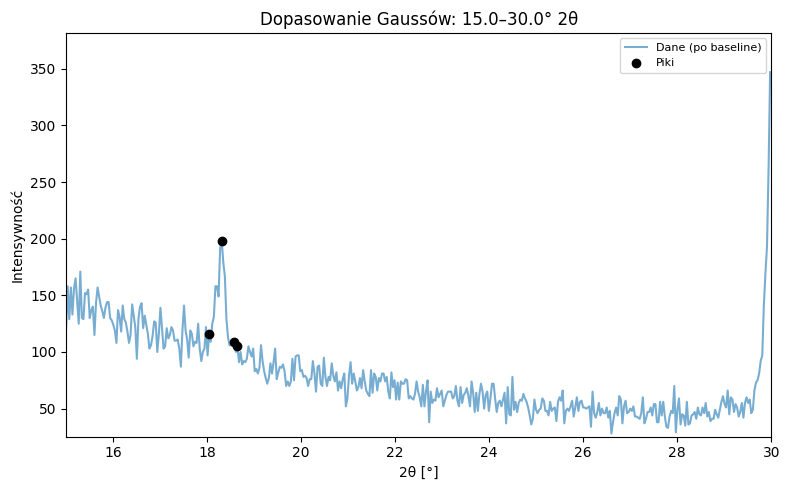

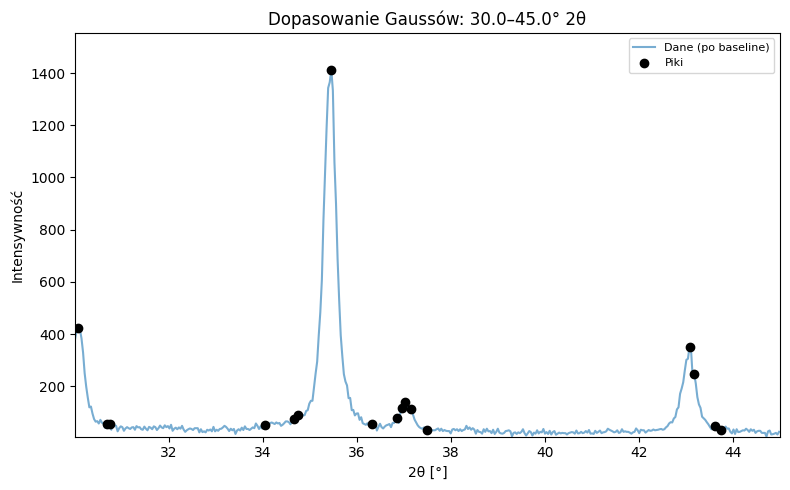

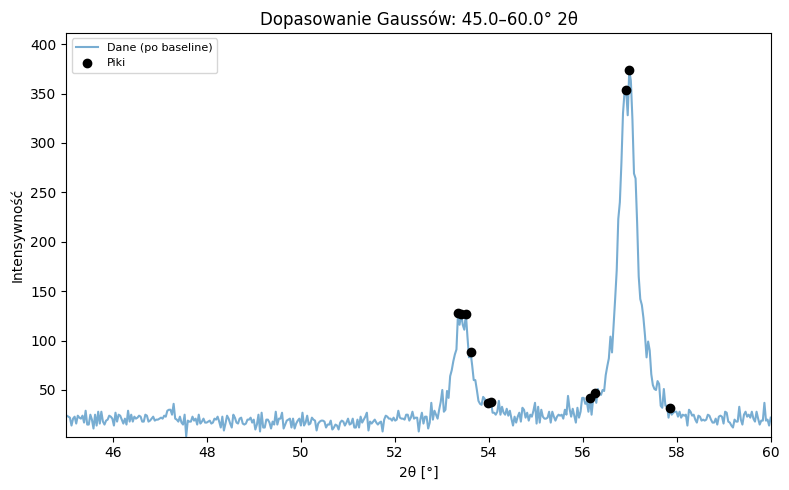

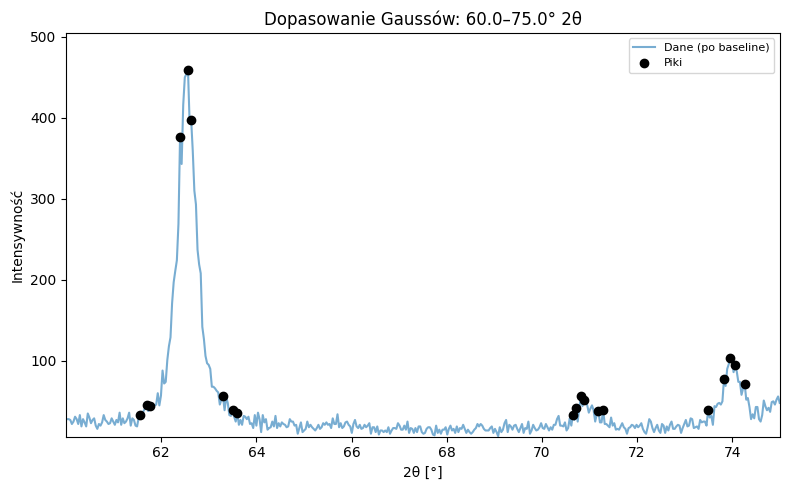

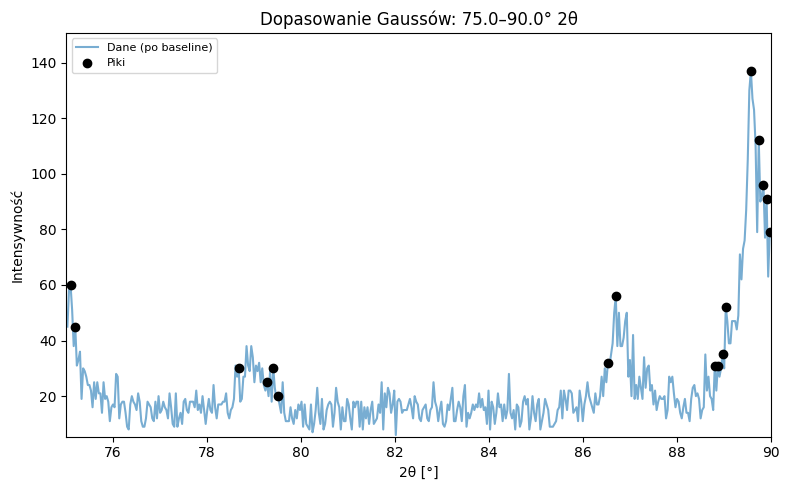

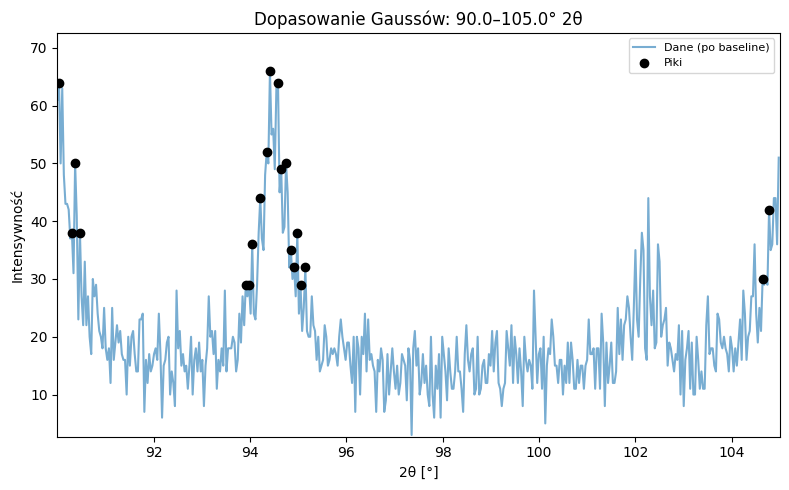

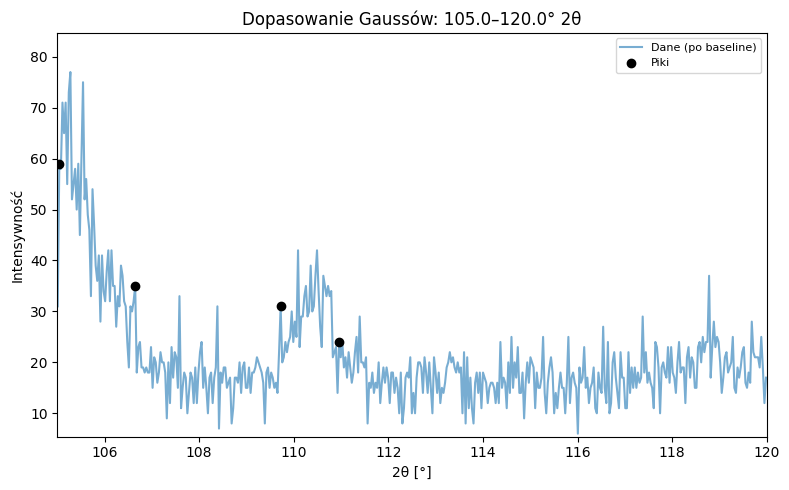

In [ ]:
plot_gauss_ap(index_peaks_f,f.counts,f.x)

In [38]:
def finding_fwhm_p(peaks, gauss_fit):
    """
    Calculate FWHM and peak positions from Gaussian fit parameters.
    gauss_fit: array-like of shape (N, 3)
        Each row: [A, mu, sigma]
    """
    # peaks = np.asarray(peaks)
    # peaks_max = np.max(peaks)
    # peaks_weight = np.zeros(len(peaks))
    # peaks_weight = peaks/peaks_max

    gauss_fit = np.asarray(gauss_fit)
    sigma = np.abs(gauss_fit[:, 2])
    mu = gauss_fit[:, 1]

    fwhm = 2 * sigma * np.sqrt(2 * np.log(2))
    t_fwhm = mu
    return fwhm, t_fwhm

In [39]:
fwhm, t_fwhm = finding_fwhm_p(x_peaks_f,gauss_fit)


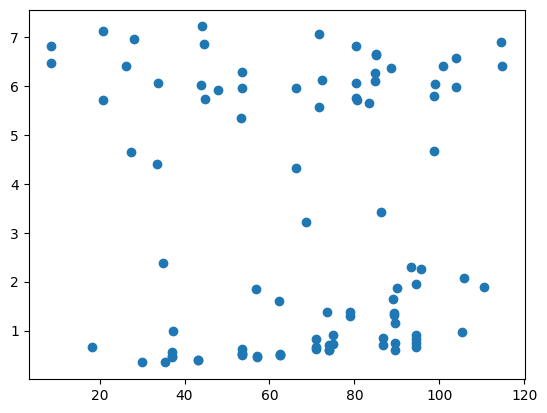

In [40]:
plt.scatter(t_fwhm,fwhm)
beta = []
for i in range(len(t_fwhm)):
    calib = cs1(t_fwhm[i])
    beta.append(fwhm[i] - calib)

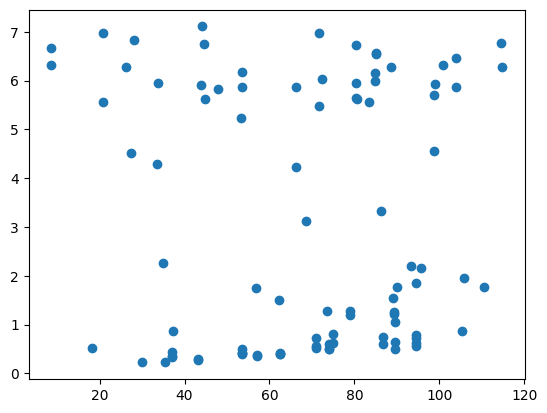

In [41]:
plt.scatter(t_fwhm,beta)

[0.20478, 0.24475, 0.2646, 0.27089, 0.29502, 0.31244, 0.3409, 0.35789, 0.35789, 0.38649, 0.40397, 0.40987, 0.43394, 0.45259, 0.45894, 0.48508, 0.50559, 0.50559, 0.54188, 0.56514, 0.56514, 0.60698, 0.63426, 0.64378, 0.68427, 0.68427, 0.71758, 0.71758, 0.72933, 0.78014, 0.82297, 0.82297, 0.83832, 0.90623]
[18.2835, 30.0743, 35.4233, 37.0544, 43.0505, 47.1354, 53.4069, 56.9313, 56.9313, 62.5158, 65.7311, 66.7844, 70.9205, 73.9548, 74.9556, 78.9155, 81.8496, 81.8496, 86.6961, 89.5905, 89.5905, 94.4157, 97.3238, 98.297, 102.2171, 102.2171, 105.1947, 105.1947, 106.1962, 110.2575, 113.3736, 113.3735, 114.4282, 118.7419]


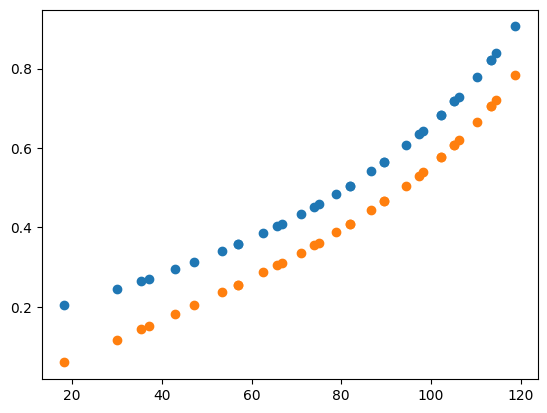

In [42]:
plt.scatter(f.two_theta,f.fwhm)
beta_f = []
for i in range(len(f.two_theta)):
    calib = cs1(f.two_theta[i])
    beta_f.append(f.fwhm[i] - calib)
plt.scatter(f.two_theta,beta_f)
print(f.fwhm)
print(f.two_theta)

In [43]:
f.read_data_of_hkl()
print(len(f.two_theta))
print(len(f.fwhm))
# f_fwhm = del_duplicates(f.fwhm,0.001)
# print(len(f_fwhm))


34
34


a = 0.09393219250302327
b = -0.15677446799262093
a = -0.01848113203962888
b = 0.006724058614898129


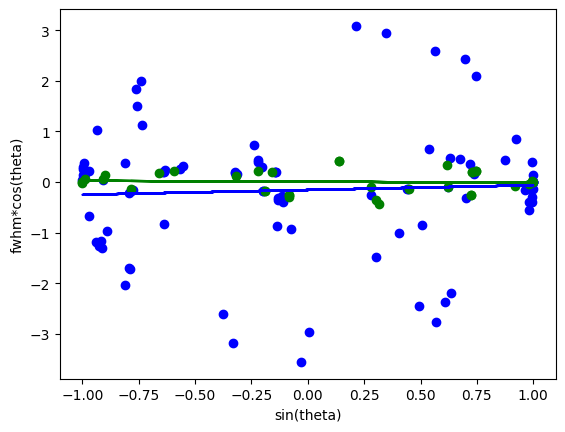

In [44]:
# fwhm,t_fwhm,_ = finding_fwhm(f.without_aparature_counts,index_corrected,f.x,gauss_fit,f.theta_start,f.step)
xx,yy = [],[]
for i in range(len(fwhm)):
    # if abs(beta[i]/2*math.cos(t_fwhm[i]/2))<3:
    yy.append(beta[i]/2*math.cos(t_fwhm[i]/2))
    xx.append(math.sin(t_fwhm[i]/2))

a, b = np.polyfit(xx, yy, 1)

print("a =", a)
print("b =", b)
y = []
for i in range(len(xx)):
    y.append(a*xx[i]+b)
plt.plot(xx,y,color = "blue")
plt.scatter(xx,yy,color = "blue")
xx,yy = [],[]
for i in range(len(f.fwhm)):
    xx.append(math.sin(f.two_theta[i]/2))
    yy.append(f.fwhm[i]/2*math.cos(f.two_theta[i]/2))
a_ref, b_ref = np.polyfit(xx, yy, 1)

print("a =", a_ref)
print("b =", b_ref)
y = []
for i in range(len(xx)):
    y.append(a_ref*xx[i]+b_ref)
plt.plot(xx,y,color = "green")
plt.scatter(xx,yy,color = "green")
plt.xlabel("sin(theta)")
plt.ylabel("fwhm*cos(theta)")
# plt.ylim(-2,2)
plt.show()
xx,yy = [],[]
# for i in range(len(diff)):
#     xx.append(math.sin(t_fwhm[i]))
#     yy.append(diff[i]*math.cos(t_fwhm[i]))
# plt.scatter(xx,yy,color = "red")
# plt.xlabel("sin(theta)")
# plt.ylabel("fwhm*cos(theta)")
# plt.show()

In [ ]:
# K = 0.94
# PI = 3.141592654
# lambda_ = f.kalpha1
# size1 = (K*lambda_)/b
# size_ref = (K*lambda_)/b_ref
# X_strain = f.xy_and_u_fitted[0]
# Y_size = f.xy_and_u_fitted[2]
# size_ref_files = (K*lambda_*180)/(PI*Y_size)
# print(size1)
# print(size_ref)
# print(size_ref_files)
# print(f.xy_and_u_fitted)
# print(lambda_)
# print(f.uvw_xy)
# # for i in range(len(f.two_theta)):
# strain1 = a/4
# strain_ref = a_ref/4
# strain_ref_files = PI*X_strain/1.8
# print(strain1)
# print(strain_ref)
# print(strain_ref_files)

-9.237231920111903
215.37024034730845
975.1272478068371
[0.42234, 0.00771505, 0.08509, 0.00285621]
1.540598
[ 4.39100e-03 -3.89000e-04  9.81300e-03  4.22342e-01  8.50950e-02
  0.00000e+00  0.00000e+00  0.00000e+00]
0.02348304812575582
-0.00462028300990722
0.7371223563835333


a = 0.006541858037496064
b = 0.002398053328586155
a = -0.01848113203962888
b = 0.006724058614898129
215.37024034730845
975.1272478068371
603.8907069901601
[0.42234, 0.00771505, 0.08509, 0.00285621]
1.540598
[ 4.39100e-03 -3.89000e-04  9.81300e-03  4.22342e-01  8.50950e-02
  0.00000e+00  0.00000e+00  0.00000e+00]
-0.00462028300990722
0.7371223563835333


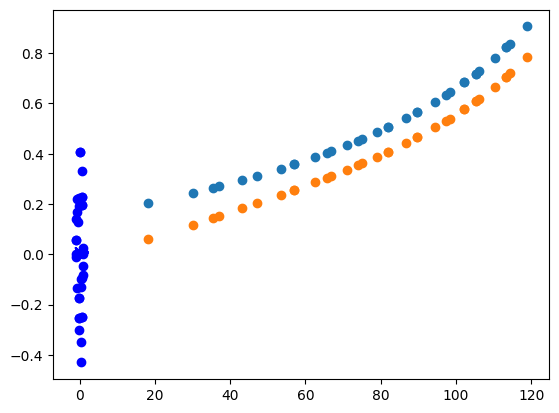

In [ ]:
# plt.scatter(f.two_theta,f.fwhm)
# beta_f = []
# for i in range(len(f.two_theta)):
#     calib = cs1(f.two_theta[i])
#     beta_f.append(f.fwhm[i] - calib)
# plt.scatter(f.two_theta,beta_f)

# xx_3,yy_3 = [],[]
# for i in range(len(f.fwhm)):
#     xx_3.append(math.sin((f.two_theta[i]/2)*PI/180))
#     yy_3.append((f.fwhm[i]*PI/180)*math.cos((f.two_theta[i]/2)*PI/180))
# a_3, b_3 = np.polyfit(xx_3, yy_3, 1)

# print("a =", a_3)
# print("b =", b_3)
# y_ = []
# for i in range(len(xx_3)):
#     y_.append(a_3*xx_3[i]+b_3)
# plt.plot(xx_3,y_,color = "blue")
# plt.scatter(xx_3,yy_3,color = "blue")
# xx_,yy_ = [],[]

# for i in range(len(f.fwhm)):
#     xx_.append(math.sin(f.two_theta[i]/2))
#     yy_.append(f.fwhm[i]/2*math.cos(f.two_theta[i]/2))
# a_, b_ = np.polyfit(xx_, yy_, 1)

# print("a =", a_)
# print("b =", b_)
# y_ = []
# for i in range(len(xx_)):
#     y_.append(a_*xx_[i]+b_)
# plt.plot(xx_,y_,color = "blue")
# plt.scatter(xx_,yy_,color = "blue")
# K = 0.94
# lambda_ = f.kalpha1
# size_ref = (K*lambda_)/b_
# X_strain = f.xy_and_u_fitted[0]
# Y_size = f.xy_and_u_fitted[2]
# size_ref_files = (K*lambda_*180)/(PI*Y_size)
# # size_ref_chat = f.scherrer_size()
# size_ref_chat = (K*lambda_)/b_3



# print(size_ref)
# print(size_ref_files)
# print(size_ref_chat)
# print(f.xy_and_u_fitted)
# print(lambda_)
# print(f.uvw_xy)

# # for i in range(len(f.two_theta)):
# strain_ref = a_/4
# strain_ref_files = PI*X_strain/1.8
# print(strain_ref)
# print(strain_ref_files)
    

2.913160870640778
-5.506601942990669
379.46888185666836


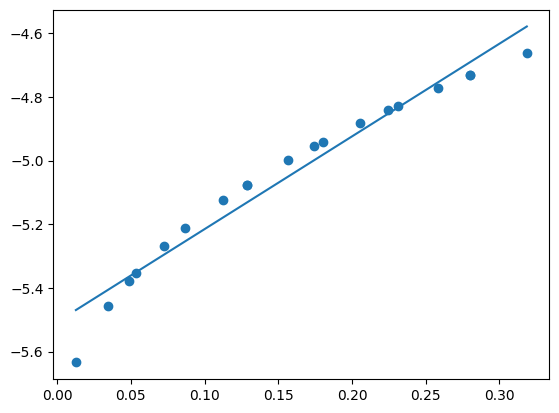

In [ ]:
# # yline = [math.log(f.fwhm[2]*PI/180),math.log(f.fwhm[4]*PI/180),math.log(f.fwhm[7]*PI/180),math.log(f.fwhm[9]*PI/180)]
# # xline = [math.log(1/(math.cos(f.two_theta[2]/2*PI/180))),math.log(1/(math.cos(f.two_theta[4]/2*PI/180))),math.log(1/(math.cos(f.two_theta[7]/2*PI/180))),math.log(1/(math.cos(f.two_theta[9]/2*PI/180)))]

# # dopasowanie scherera ale z logarytmem (S-M) podobno dobrze idk 
# xline,yline = [],[]
# for i in range(len(f.two_theta)-15):
#     xline.append(math.log(1/(math.cos(f.two_theta[i]/2*PI/180))))
#     yline.append(math.log(f.fwhm[i]*PI/180))
# plt.scatter(xline,yline)

# aschr, bschr= np.polyfit(xline, yline, 1)
# y_line = []
# for i in range(len(xline)):
#     y_line.append(aschr*xline[i]+bschr)
# plt.plot(xline,y_line)
# print(aschr)
# print(bschr)
# size_schr = 1*f.kalpha1/math.e**bschr
# print(size_schr)

0.001635464509374016
0.002398053328586155
642.4369223299576
-0.013599353191316443
0.07508649429187604
20.517644544855045


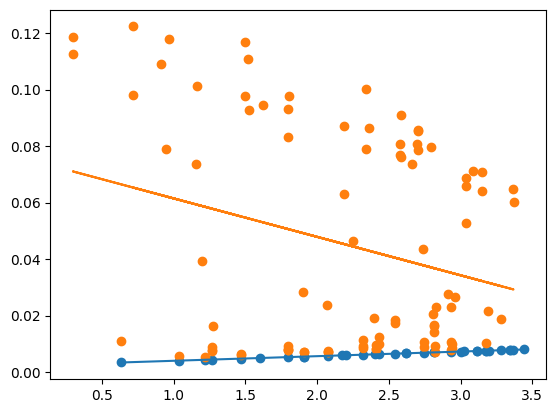

In [79]:
#załóżmy że to jest dobrze 

xlinewh,ylinewh = [],[]
for i in range(len(f.two_theta)):
    xlinewh.append(4*(math.sin(f.two_theta[i]/2*PI/180)))
    ylinewh.append((f.fwhm[i]*PI/180)*(math.cos(f.two_theta[i]/2*PI/180)))
plt.scatter(xlinewh,ylinewh)

awh, bwh= np.polyfit(xlinewh, ylinewh, 1)
y_linewh = []
for i in range(len(xlinewh)):
    y_linewh.append(awh*xlinewh[i]+bwh)
plt.plot(xlinewh,y_linewh)
print(awh)
print(bwh)
size_wh = 1*f.kalpha1/bwh
print(size_wh)
#załóżmy że to jest dobrze 

xlinewh,ylinewh = [],[]
for i in range(len(t_fwhm)):
    xlinewh.append(4*(math.sin(t_fwhm[i]/2*PI/180)))
    ylinewh.append((math.sqrt(fwhm[i]**2 - cs1(t_fwhm[i])**2))*PI/180*(math.cos(t_fwhm[i]/2*PI/180)))
plt.scatter(xlinewh,ylinewh)

awh, bwh= np.polyfit(xlinewh, ylinewh, 1)
y_linewh = []
for i in range(len(xlinewh)):
    y_linewh.append(awh*xlinewh[i]+bwh)
plt.plot(xlinewh,y_linewh)
print(awh)
print(bwh)
size_wh = 1*f.kalpha1/bwh
print(size_wh)

-0.018929465993472935
0.08288704456715418
18.586716513360834


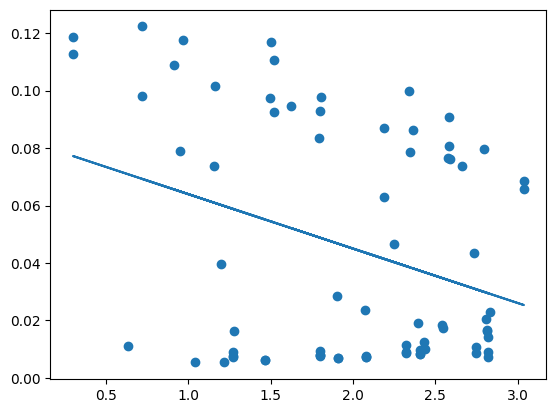

In [ ]:
#załóżmy że to jest dobrze 

xlinewh,ylinewh = [],[]
for i in range(len(t_fwhm)):
    xlinewh.append(4*(math.sin(t_fwhm[i]/2*PI/180)))
    ylinewh.append((math.sqrt(fwhm[i]**2 - cs1(t_fwhm[i])**2))*PI/180*(math.cos(t_fwhm[i]/2*PI/180)))
plt.scatter(xlinewh,ylinewh)

awh, bwh= np.polyfit(xlinewh, ylinewh, 1)
y_linewh = []
for i in range(len(xlinewh)):
    y_linewh.append(awh*xlinewh[i]+bwh)
plt.plot(xlinewh,y_linewh)
print(awh)
print(bwh)
size_wh = 1*f.kalpha1/bwh
print(size_wh)